In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import dateutil.parser
import numpy as np

from tqdm import tqdm
from datetime import timedelta
from sklearn.decomposition import NMF


In [2]:
tqdm.pandas()

In [3]:
billboard_hot_100 = pd.read_csv("billboard_hot_100.csv")
billboard_hot_100["first_day_of_the_week"] = pd.to_datetime(billboard_hot_100["first_day_of_the_week"],
                                                            infer_datetime_format=True)
billboard_hot_100["year"] = billboard_hot_100["first_day_of_the_week"].dt.year

billboard_hot_100.head()

,Unnamed: 0,first_day_of_the_week,artist,song_name,position,last_week_position,peak_position,weeks_on_chart,songwriters,producers,promotion_label,year
0,0,1958-09-08,Domenico Modugno,Nel Blu Dipinto Di Blu (Volare),1,1.0,1,6,"F.Migliacci, D.Modugno",Not Listed,Decca,1958
1,1,1958-09-08,The Elegants,Little Star,2,2.0,1,6,"V.Picone, A.Venosa",Not Listed,Apt,1958
2,2,1958-09-08,The Everly Brothers,Bird Dog,3,3.0,3,6,B.Bryant,Not Listed,Cadence,1958
3,3,1958-09-08,Jimmy Clanton And His Rockets,Just A Dream,4,4.0,4,6,Not Listed,Not Listed,Ace,1958
4,4,1958-09-08,Perez Prado And His Orchestra,Patricia,5,6.0,2,6,"B.Marcus, P.Prado",Not Listed,RCA Victor,1958


In [4]:
plt.rcParams.update({'font.size': 15})

In [5]:
billboard_hot_100["top_position"] = billboard_hot_100.groupby(
    ["artist", "song_name"])["position"].transform("min")

In [6]:
# concatenate artist and song name
billboard_hot_100["artist_song"] = billboard_hot_100["artist"] + " - " +\
    billboard_hot_100["song_name"]
billboard_hot_100["first_week"] = billboard_hot_100.groupby(["artist", "song_name"])["first_day_of_the_week"].transform("min")
billboard_hot_100["last_week"] = billboard_hot_100.groupby(["artist", "song_name"])["first_day_of_the_week"].transform("max")
billboard_hot_100["start_end_week_diff"] = (billboard_hot_100["last_week"] - billboard_hot_100["first_week"]).dt.days / 7

In [7]:
min_first_week = billboard_hot_100["first_day_of_the_week"].min().to_pydatetime()
billboard_hot_100["first_day_of_the_week_copy"] = billboard_hot_100["first_day_of_the_week"]
billboard_hot_100["first_day_of_the_week"] = billboard_hot_100.progress_apply(lambda row:
            int(((min_first_week + timedelta(
                days=(row["first_day_of_the_week"] - row["first_week"]).days)) - min_first_week).days / 7), axis=1)

100%|██████████| 336087/336087 [00:07<00:00, 47019.53it/s]


In [8]:
billboard_hot_100 = billboard_hot_100[(billboard_hot_100["start_end_week_diff"] <= 100) & (billboard_hot_100["top_position"] >= 50)]

pv_table = billboard_hot_100[billboard_hot_100["start_end_week_diff"] <= 100].pivot_table(index="first_day_of_the_week",
        columns="artist_song", values="position", fill_value=101)

In [9]:
pv_table

artist_song,"""Groove"" Holmes - What Now My Love","""Pookie"" Hudson - I Know I Know","""Weird Al"" Yankovic - Amish Paradise","""Weird Al"" Yankovic - Canadian Idiot","""Weird Al"" Yankovic - Fat","""Weird Al"" Yankovic - I Lost On Jeopardy","""Weird Al"" Yankovic - King Of Suede","""Weird Al"" Yankovic - Ricky",$NOT & A$AP Rocky - Doja,'N Sync - I Drive Myself Crazy,...,twenty one pilots - Cancer,twenty one pilots - Fairly Local,twenty one pilots - Jumpsuit,twenty one pilots - My Blood,twenty one pilots - Nico And The Niners,twenty one pilots - Shy Away,twenty one pilots - Tear In My Heart,will.i.am - It's A New Day,will.i.am Featuring Miley Cyrus - Fall Down,"will.i.am Featuring Miley Cyrus, French Montana, Wiz Khalifa & DJ Mustard - Feelin' Myself"
first_day_of_the_week,,,,,,,,,,,,,,,,,,,,,
0,98,96,65,82,99,83,77,90,87,92,...,91,84,60,81,79,87,82,78,58,96
1,98,101,62,94,100,81,66,83,101,78,...,101,101,50,101,101,101,101,101,101,99
2,96,101,58,98,101,97,62,74,101,67,...,101,101,88,101,101,101,101,101,101,101
3,101,101,53,101,101,101,62,68,101,67,...,101,101,101,101,101,101,101,101,101,101
4,101,101,53,101,101,101,91,63,101,69,...,101,101,101,101,101,101,101,101,101,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,101,101,101,101,101,101,101,101,101,101,...,101,101,101,101,101,101,101,101,101,101
80,101,101,101,101,101,101,101,101,101,101,...,101,101,101,101,101,101,101,101,101,101
81,101,101,101,101,101,101,101,101,101,101,...,101,101,101,101,101,101,101,101,101,101


In [10]:
nmf = NMF(n_components=6, init='random', random_state=0)
nmf.fit(pv_table)

c:\Users\cutie\source\repos\mgr\env\Lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF(init='random', n_components=6, random_state=0)

In [11]:
nmf_features = nmf.transform(pv_table)

In [12]:
def display_components(model, song_names, num_top_positions):
    # iterate through topics in topic-term matrix, 'H' aka
    # model.components_
    for ix, archetype in enumerate(model.components_):
        #print topic, topic number, and top words
        print("\nArchetype ", ix)
        print(", ".join([song_names[i] \
             for i in archetype.argsort()[:-num_top_positions - 1:-1]]))

In [13]:
display_components(nmf, billboard_hot_100["artist_song"].values, 5)


Archetype  0
Tony Bennett - Don't Wait Too Long, The Browns Featuring Jim Edward Brown - Send Me The Pillow You Dream On, Martin Denny and His Orchestra - A Taste Of Honey, The Intruders - A Love That's Real, The Playmates - Star Love

Archetype  1
Bill Doggett - Honky Tonk (Part 2), Gloria Lynne - Be Anything (But Be Mine), Jack Greene - There Goes My Everything, The Blendells - La La La La La, Joe Tex - Woman Like That, Yeah

Archetype  2
The Bermudas - Donnie, Floyd Cramer - Your Last Goodbye, The Third Rail - Run, Run, Run, Santo & Johnny - I'll Remember (In The Still Of The Night), Tommy Hunt - I Am A Witness

Archetype  3
Claude King - The Comancheros, Bobby Vee - Yesterday And You (Armen's Theme), Solomon Burke - I'm Hanging Up My Heart For You, The Platters - You're Making A Mistake, Red Sovine - Giddyup Go

Archetype  4
Wayne Newton And The Newton Brothers - Heart! (I Hear You Beating), Major Lance - It Ain't No Use, The Gunter Kallmann Chorus - Wish Me A Rainbow, Arthur Conl

In [14]:
# Create a DataFrame: components_df
components_df = pd.DataFrame(nmf.components_, columns=billboard_hot_100["artist_song"].drop_duplicates().values)
components_df

,Tommy Sands And The Raiders - Blue Ribbon Baby,Faron Young - Alone With You,Chuck Willis - My Life,Boots Brown And His Blockbusters - Cerveza,Eydie Gorme - Gotta Have Rain,Jimmy Bowen with the Rhythm Orchids - By The Light Of The Silvery Moon,The Champs - Chariot Rock,"The Kirby Stone Four - Baubles, Bangles And Beads",The Three G's - Let's Go Steady For The Summer,Jack Scott - Leroy,...,Juice WRLD - Face 2 Face,Pentatonix Featuring Meghan Trainor - Kid On Christmas,SZA - Conceited,SZA - Far,Nengo Flow & Bad Bunny - Gato de Noche,Carin Leon X Grupo Frontera - Que Vuelvas,Fuerza Regida X Grupo Frontera - Bebe Dame,SZA - Too Late,SZA Featuring Ol' Dirty Bastard - Forgiveless,A Boogie Wit da Hoodie Featuring Kodak Black - Water (Drowning Pt. 2)
0,1.968642,2.831154,6.429308,2.968465,3.543549,1.586831,6.232031,5.780456,3.239798,4.805946,...,3.862694,3.993966,5.351701,1.699496,3.321942,1.655872,5.054265,2.874817,0.641166,2.845480
1,2.953114,2.187915,0.000000,3.052126,3.102327,4.768043,0.067780,1.217323,1.269729,4.036707,...,2.283404,2.587746,2.281738,1.821366,1.107601,5.351805,1.760828,1.085161,5.091308,3.503164
2,4.718608,3.862366,4.050113,3.294174,2.082289,4.240609,4.553553,2.280719,4.067621,1.420683,...,2.294011,1.876397,2.781962,5.891283,4.335857,2.948967,1.701396,5.251474,4.796296,2.795239
3,4.598746,4.493809,1.832843,4.282303,3.939545,4.273451,5.502153,4.394585,4.698528,3.192456,...,4.125212,3.990849,4.208277,5.038933,4.704567,3.795859,3.745540,4.720532,4.302343,4.047190
4,4.218363,4.192702,5.671062,3.454821,3.514653,3.299004,0.531437,4.159687,4.202715,3.802693,...,3.580416,3.342007,0.351602,4.745508,3.938842,3.674031,2.451509,3.996312,3.973402,3.699557
5,4.572074,4.996441,0.068320,5.010725,5.442150,4.465701,2.711393,1.570306,5.016532,1.950349,...,5.461379,5.577150,4.853949,4.453692,5.024237,5.065719,5.900747,4.862775,4.596835,5.200531


In [15]:
# get all artist-songs for archetypes
archetypes = {i: [] for i in range(6)}
for artist_song in components_df.columns:
    archetype = components_df[artist_song].argmax()
    archetypes[archetype].append(artist_song)


In [16]:
nmf_features_pd = pd.DataFrame(nmf_features)

nmf_features_pd

,0,1,2,3,4,5
0,5.726443,5.309443,4.187322,2.974801,4.242861,2.799352
1,3.367369,3.838591,3.732688,2.553721,4.632012,6.899206
2,2.417575,2.993548,3.456259,2.156831,4.449367,9.009215
3,2.347072,2.556368,3.086237,2.053648,3.755954,10.529022
4,3.024303,2.610768,2.899097,2.760589,2.425715,10.883348
...,...,...,...,...,...,...
79,8.299396,5.618956,4.513407,3.087528,4.108718,3.369421
80,8.299973,5.619024,4.513211,3.086720,4.108307,3.370184
81,8.299735,5.618927,4.513208,3.086857,4.108434,3.370306
82,8.299416,5.620286,4.512687,3.087597,4.108890,3.368981


In [17]:
approx_song_i = np.matmul(nmf_features_pd, components_df.values[:, 54])

In [18]:
rows_to_add = []

grouped = billboard_hot_100.groupby(["artist", "song_name"])

for name, group in tqdm(grouped):
    max_week = group["first_day_of_the_week"].max()

    for row_index, row in group.iterrows():
        if row["first_day_of_the_week"] == max_week:
            week = row["first_day_of_the_week"] + 1

            while week <= 101:
                rows_to_add.append({
                    "artist_song": row["artist_song"],
                    "weeks_on_chart": row["weeks_on_chart"],
                    "position": 101,
                    "first_day_of_the_week": week,
                    "top_position": row["top_position"],
                    "first_week": row["first_week"]
                })
                week += 1

billboard_100_with_empty_weeks = pd.concat([billboard_hot_100[["artist_song",
    "weeks_on_chart", "position", "first_day_of_the_week", "first_week", "top_position"]], pd.DataFrame(rows_to_add)], ignore_index=True)

100%|██████████| 14372/14372 [00:30<00:00, 473.17it/s]


6it [00:10,  1.82s/it]


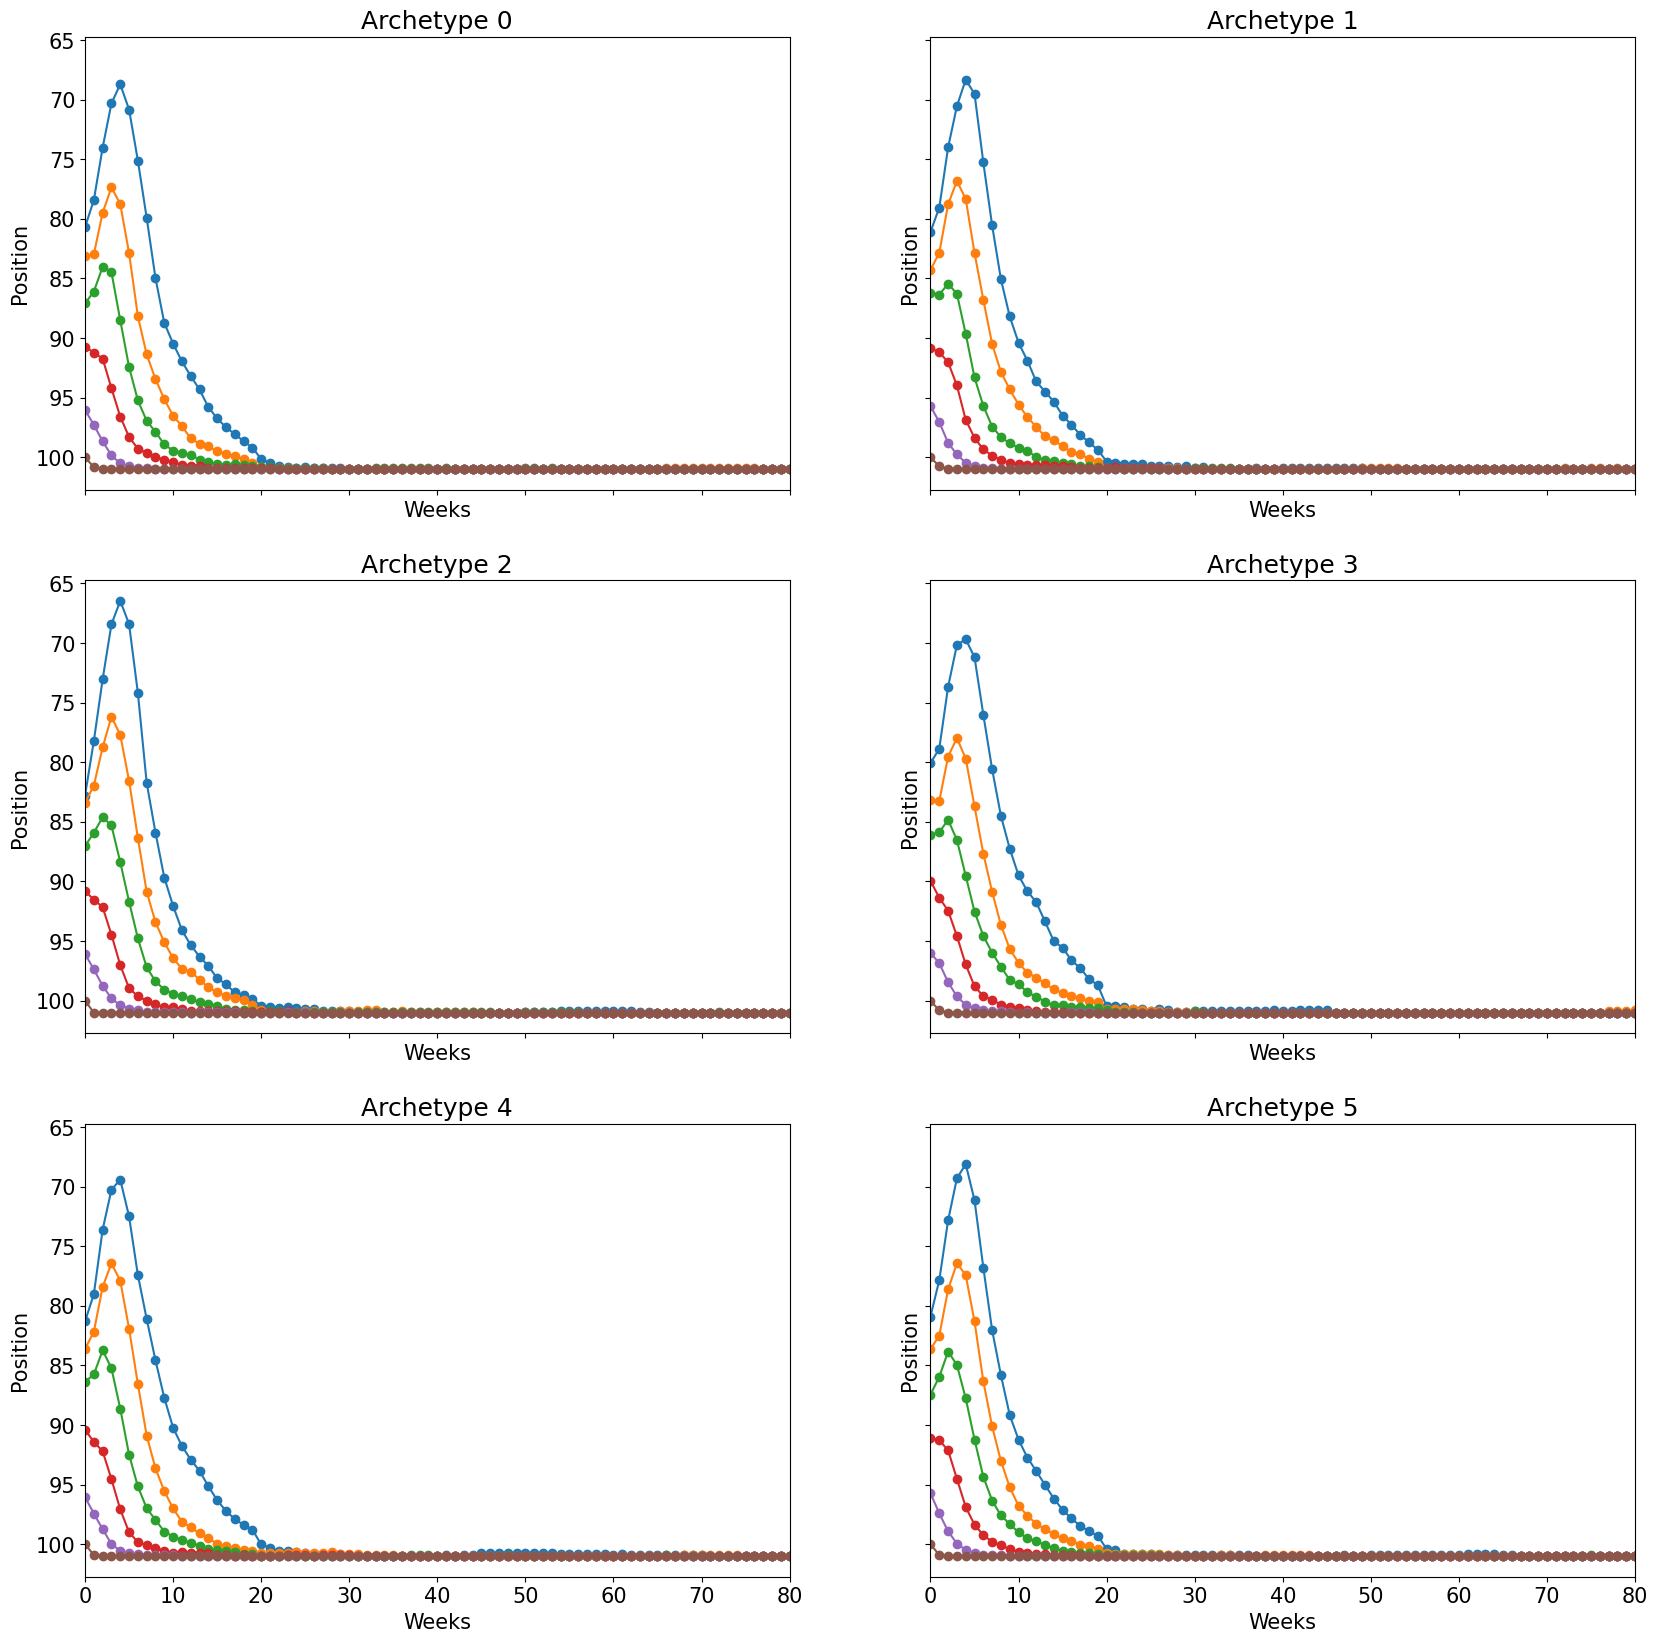

In [19]:
# plot all trajectories of archetypes
fig, axes = plt.subplots(int(len(nmf.components_)/2), 2, figsize=(20, 20), sharex=True, sharey=True)
row_i, col_i = 0, 0

for ix, archetype in tqdm(enumerate(nmf.components_)):
    for top_position in range(50, 110, 10):
        songs_ids_from_archetype = archetypes[ix]
        songs_from_archetype = billboard_hot_100[billboard_hot_100["artist_song"].isin(songs_ids_from_archetype)]
        songs_from_archetype = songs_from_archetype[(songs_from_archetype["top_position"] >= top_position) &\
            (songs_from_archetype["top_position"] < top_position + 10)][["artist_song"]]
        songs_from_archetype = songs_from_archetype[["artist_song"]].drop_duplicates().merge(
            billboard_100_with_empty_weeks[["artist_song",
                "position", "first_day_of_the_week", "first_week"]], on=["artist_song"], how="left")
        axes[row_i, col_i].plot(songs_from_archetype.groupby("first_day_of_the_week")["position"].mean(),
            marker='o')
        
    axes[row_i, col_i].set_title(f"Archetype {ix}")
    axes[row_i, col_i].set_xlabel("Weeks")
    axes[row_i, col_i].set_ylabel("Position")

    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1 

plt.xlim(0, 80)
plt.gca().invert_yaxis()
plt.show()

100%|██████████| 2000/2000 [00:02<00:00, 871.81it/s]
6it [00:09,  1.62s/it]


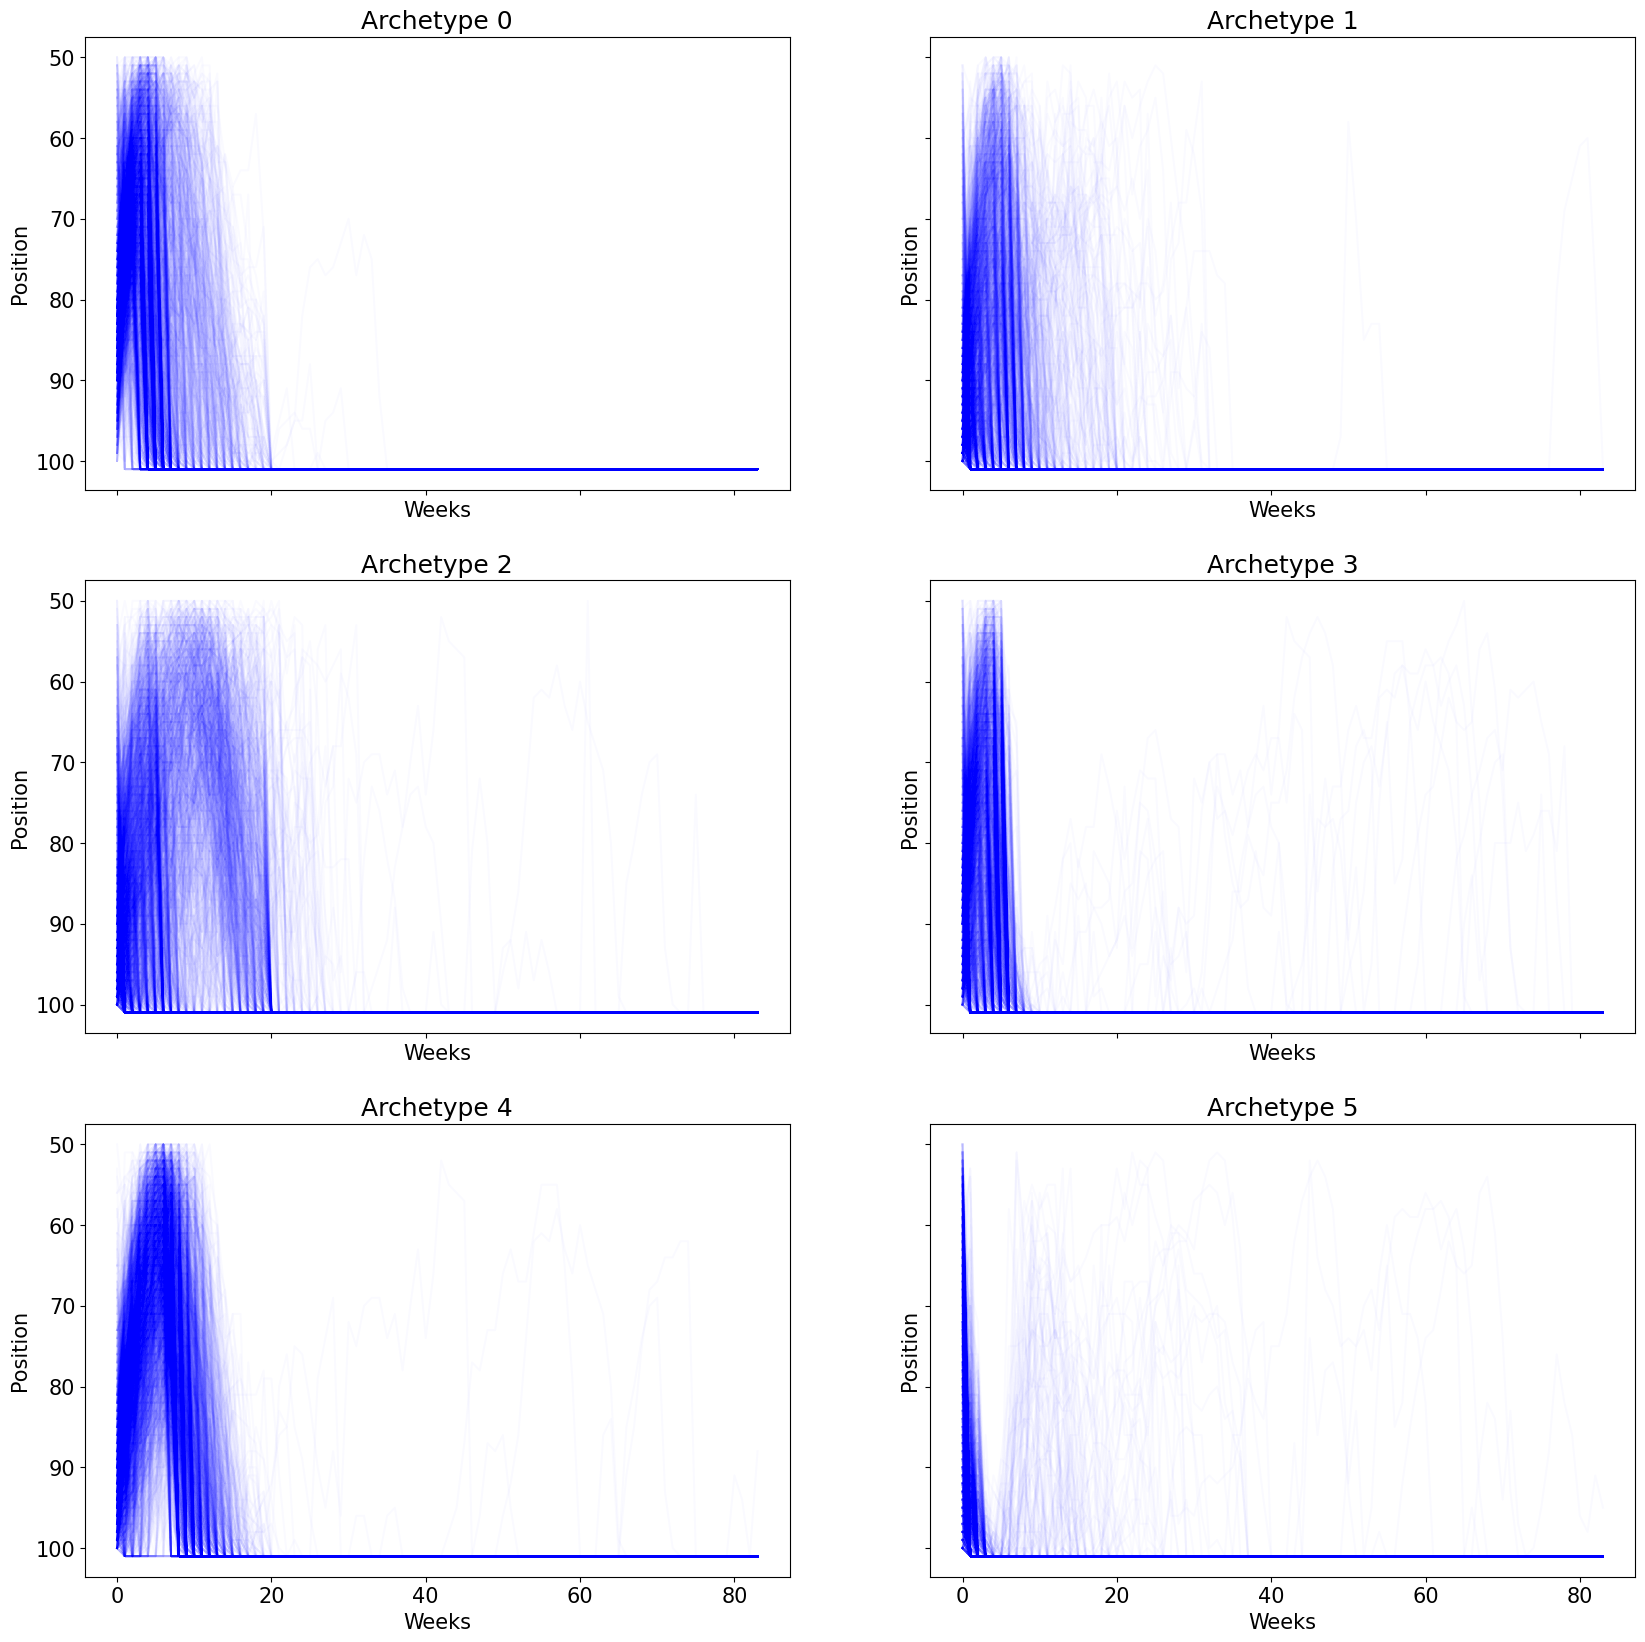

In [24]:
fig, axes = plt.subplots(int(len(nmf.components_)/2), 2, figsize=(20, 20), sharex=True, sharey=True)
row_i, col_i = 0, 0

for ix, archetype in tqdm(enumerate(nmf.components_)):
    for i in tqdm(archetype.argsort()[:-2000 - 1:-1]):
        # songs_ids_from_archetype = archetypes[ix]
        # songs_from_archetype = billboard_hot_100[billboard_hot_100["artist_song"].isin(songs_ids_from_archetype)]
        trajectory = pv_table.iloc[:, i].values
        #trajectory = trajectory[trajectory != 101]
        axes[row_i, col_i].plot(trajectory, alpha=0.02, color="blue")
    
    axes[row_i, col_i].set_title(f"Archetype {ix}")
    axes[row_i, col_i].set_xlabel("Weeks")
    axes[row_i, col_i].set_ylabel("Position")


    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1 

plt.gca().invert_yaxis()
plt.show()

100%|██████████| 2000/2000 [00:02<00:00, 935.01it/s] 
6it [00:18,  3.02s/it]


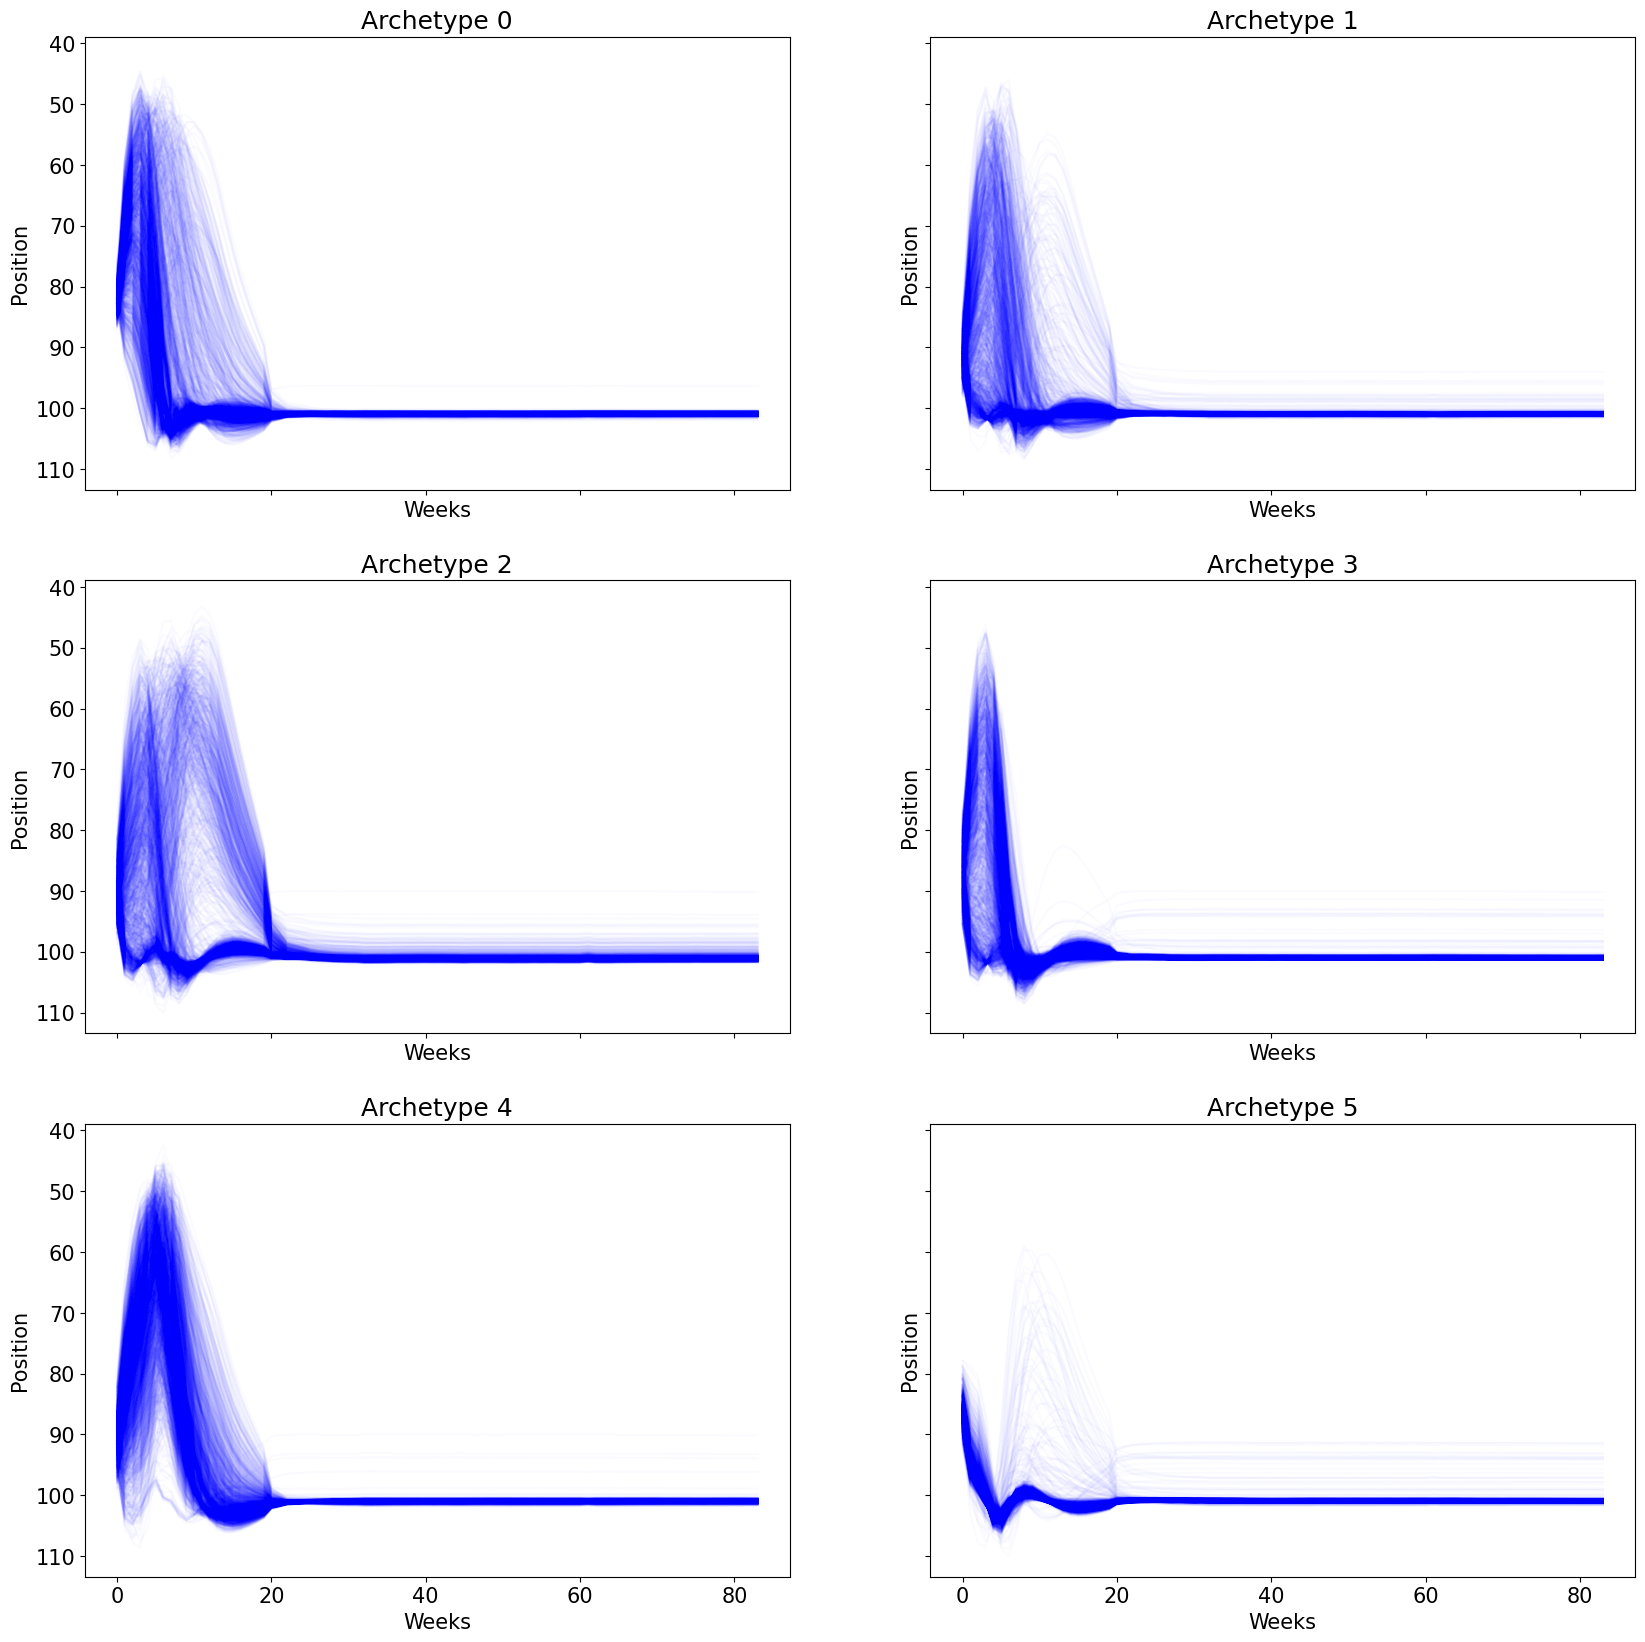

In [25]:
fig, axes = plt.subplots(int(len(nmf.components_)/2), 2, figsize=(20, 20), sharex=True, sharey=True)
row_i, col_i = 0, 0

for ix, archetype in tqdm(enumerate(nmf.components_)):
    for i in tqdm(archetype.argsort()[:-2000 - 1:-1]):
        # songs_ids_from_archetype = archetypes[ix]
        # songs_from_archetype = billboard_hot_100[billboard_hot_100["artist_song"].isin(songs_ids_from_archetype)]
        trajectory = np.matmul(nmf_features_pd, components_df.values[:, i])
        #trajectory = trajectory[trajectory != 101]
        axes[row_i, col_i].plot(trajectory, alpha=0.02, color="blue")
    
    axes[row_i, col_i].set_title(f"Archetype {ix}")
    axes[row_i, col_i].set_xlabel("Weeks")
    axes[row_i, col_i].set_ylabel("Position")


    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1 

plt.gca().invert_yaxis()
plt.show()

In [22]:
billboard_hot_100["archetype"] = billboard_hot_100["artist_song"].progress_apply(lambda x: components_df[x].argmax())


100%|██████████| 83285/83285 [00:04<00:00, 16767.67it/s]


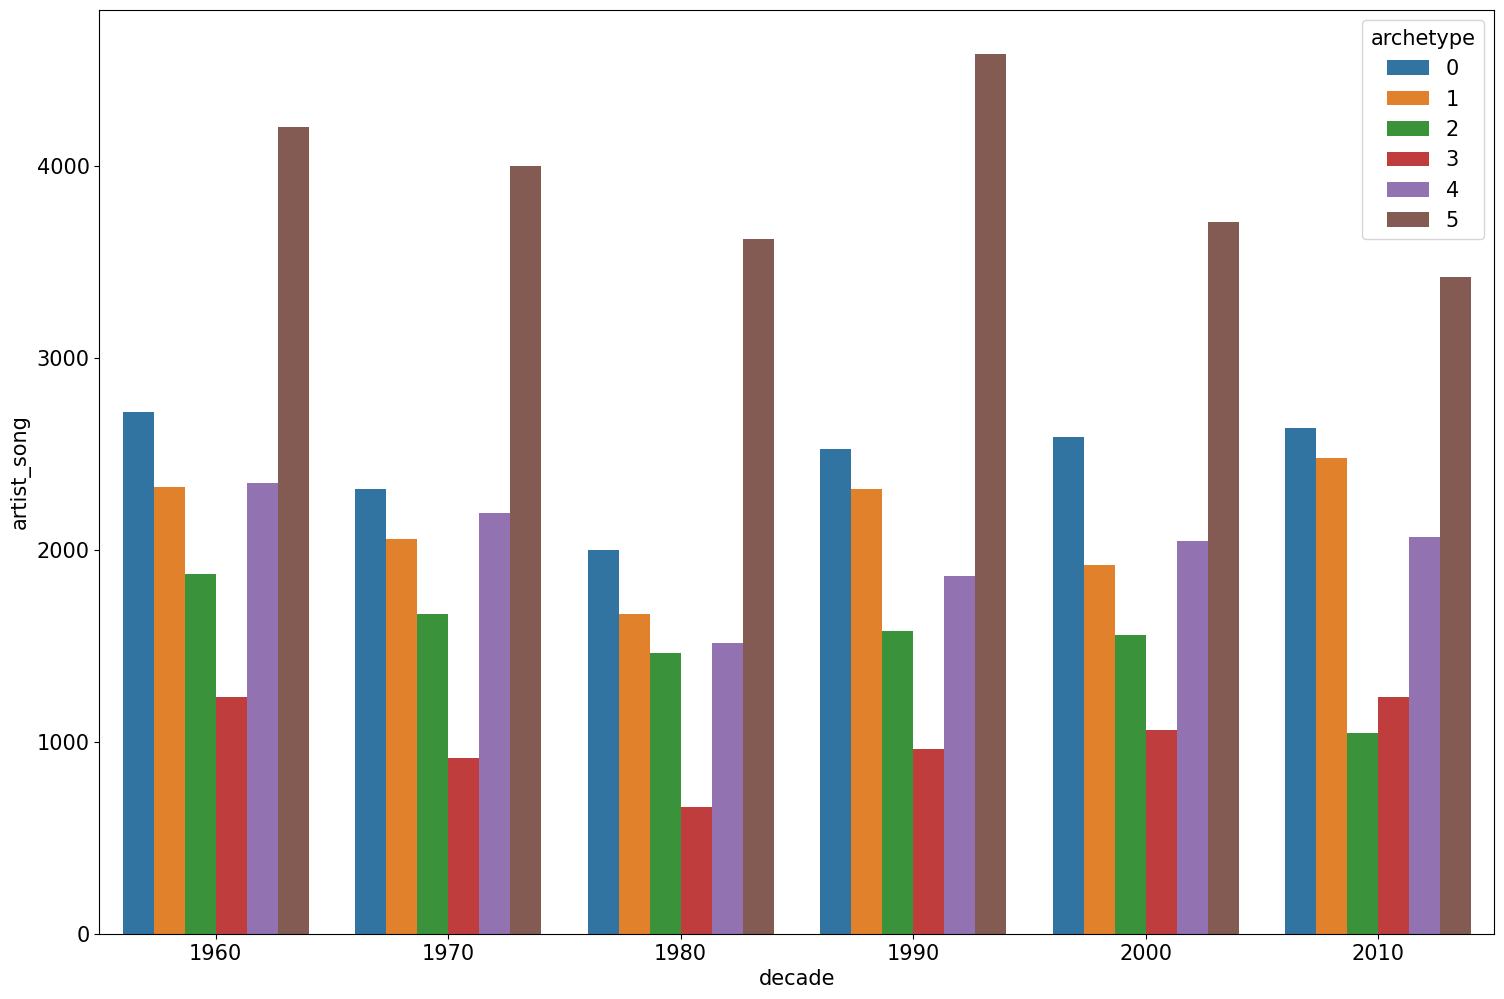

In [23]:
import seaborn as sns

plt.figure(figsize=(18, 12))

billboard_hot_100["year"] = billboard_hot_100["first_day_of_the_week_copy"].dt.year
billboard_hot_100["decade"] = billboard_hot_100["year"].apply(lambda x: x - x % 10)
counts = billboard_hot_100[["archetype", "decade", "artist_song"]].groupby(["archetype", "decade"]).count().reset_index()
counts = counts[(counts["decade"] != 2020) & (counts["decade"] != 1950)]
sns.barplot(counts, x="decade", y="artist_song", hue="archetype")

plt.show()